## Functional connectivity and neural networks: first look
**This is a step-by-step guide to using a simple neural network model for functional connectivity-based classification.**
<br>
The goal of this tutorial is to show how we can use a neural network approach to classify functional connectivity data.

### Table of Contents

#### [Setup and Dataset](#Setup_and_Dataset)
- in this section, we download and examine the data after importing all the necessary libraries;

#### [Decomposition](#D)
- in this section, we use independent component analysis to extact functional connectivity coefficients;

#### [The Neural Network Way](#nn)
- in this section, we build a neural network using the extracted coefficients to make the classification.

## Setup and Dataset <a name='Setup_and_Dataset'></a>

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting
import nibabel as nib
from tkinter.filedialog import askdirectory, askopenfilenames
import random

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
#Fixing seed for reproducibility
np.random.seed(0) 

In [3]:
# data_folder = Path(askdirectory(title="Select the folder where the fMRI data is saved")).absolute()
# data_files = [f for f in data_folder.glob('*') if f.is_file()]
data_files = askopenfilenames(title="Select the fMRI files to import")

In [4]:
#Getting the functional files
# func = adhd_data.func[1:]
func = list(data_files[:])
print(func)

['C:/Users/mihir/OneDrive/Programs/fMRI_analysis/data/subject/10159.nii.gz', 'C:/Users/mihir/OneDrive/Programs/fMRI_analysis/data/subject/10523.nii.gz', 'C:/Users/mihir/OneDrive/Programs/fMRI_analysis/data/subject/11121.nii.gz']


In [36]:
sampling_img = random.choice(data_files)
sample_img = nib.load(sampling_img)
sample_img = sample_img.slicer[:, :, :, int(img.shape[-1]/2)]
sample_img_header = sample_img.header 
afn = sample_img_header.get_best_affine()
shp = sample_img_header.get_data_shape()

In [37]:
ni_imgs = []
for fname in data_files:
    img = nib.load(fname)
    ni_imgs.append( img.slicer[:, :, :, int(img.shape[-1]/2)] )

In [38]:
ni_imgs

## Decomposition <a name='D'></a>

We use Nilearn's method for group-level ICA (CanICA) which allows for control over single subject variability, especially given that we are interested in functional networks.
For this, we:
1. get the independent components using masker_.inverse_transform;
2. plot these components;
3. use NiftiMapsMasker function to "summarize" the brain signals we obtained using ICA;
4. transform the extracted data to time-series by using the fit_transform method.
5. get functional connectivity coefficients using the ConnectivityMeasure function after having compared three different measures of fuctional connectivity;
6. examine resulting connectivity across all subjects

In [52]:
#Using nilearn's individual component analysis for group level
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20, mask_strategy='background', target_affine=afn, target_shape=shp)
canica.fit(ni_imgs)


CanICA(mask_strategy='background',
       target_affine=array([[-2.99835730e+00,  8.90391760e-08,  1.32352978e-01,
         8.72669601e+01],
       [-6.08733147e-02,  2.36968327e+00, -2.45162821e+00,
        -3.05467377e+01],
       [ 7.84087181e-02,  1.83972859e+00,  3.15784764e+00,
        -7.10929871e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]),
       target_shape=(64, 64, 34))

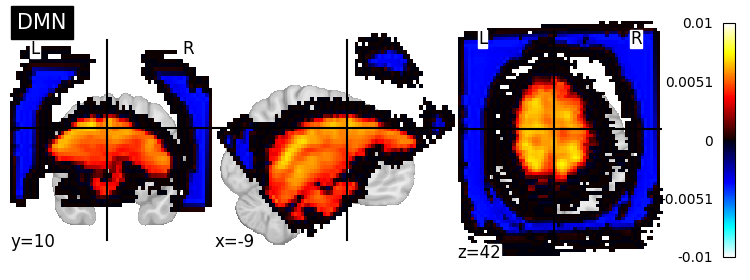

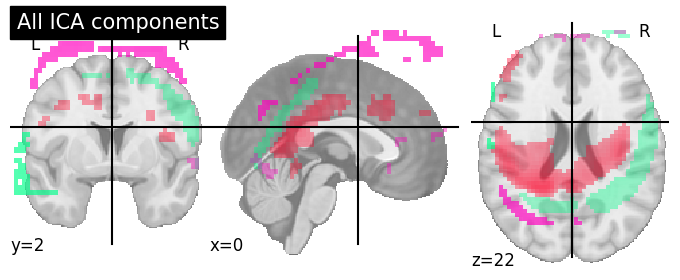

In [53]:
#Retrieving the components
components = canica.components_

#Using a masker to project into the 3D space
components_img = canica.masker_.inverse_transform(components)

#Plotting the default mode network (DMN) without region extraction
plotting.plot_stat_map(image.index_img(components_img, 0), title='DMN')
plotting.show()

#Plotting all the components
plotting.plot_prob_atlas(components_img, title='All ICA components')
plotting.show()

In [54]:
#Using a filter to extract the regions time series 
from nilearn import input_data
masker = input_data.NiftiMapsMasker(components_img, smoothing_fwhm=6,
                         standardize=False, detrend=True,
                         t_r=2.5, low_pass=0.1,
                         high_pass=0.01)



#Computing the regions signals and extracting the phenotypic information of interest
subjects = []
adhds = []
sites = []
labels = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd == 1:
        adhds.append(time_series)    
    sites.append(phenotypic['site'])
    labels.append(phenotypic['adhd'])

NameError: name 'adhd_data' is not defined

In [55]:
#Comparing the three types of functional connectivity between the regions of interest
from nilearn.connectome import ConnectivityMeasure

connectivity_biomarkers = {}

kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['tangent'].shape[1]))

ValueError: Each subject must be 2D numpy.ndarray.
 You provided []

In [ ]:
#Stratifying the data to use for comparison

from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites, labels)]
cv = StratifiedKFold(n_splits=3)

In [ ]:
#Classifying using the connectivity coefficients and linear support vector
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=labels,
                                cv=cv,
                                groups=labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

In [ ]:
#Visualizing results and accuracy
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()

In [ ]:
#Displaying the connectomes for the most accurate kind of functional connectivity
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(subjects)


for i in range(40):
    plt.figure(figsize=(8,6))
    plt.imshow(correlation_matrices[i], vmax=.20, vmin=-.20, cmap='RdBu_r')
    plt.colorbar()
    plt.title('Connectivity matrix of subject {} with label {}'.format(i, labels[i]))

In [ ]:
#Separating the correlation matrices between treatment and control subjects
adhd_correlations = []
control_correlations = []
for i in range(40):
    if labels[i] == 1:
        adhd_correlations.append(correlation_matrices[i])
    else:
        control_correlations.append(correlation_matrices[i])

In [ ]:
#Getting the mean correlation matrix across all treatment subjects
mean_correlations_adhd = np.mean(adhd_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Getting the mean correlation matrix across all control subjects
mean_correlations_control = np.mean(control_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Visualizing the mean correlation
plotting.plot_matrix(mean_correlations_adhd, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for ADHD')

plotting.plot_matrix(mean_correlations_control, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for controls')

#Getting the center coordinates from the component decomposition to use as atlas labels
coords = plotting.find_probabilistic_atlas_cut_coords(components_img)

In [ ]:
#Plotting the connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlations_adhd, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for ADHD')

plotting.plot_connectome(mean_correlations_control, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for controls')
plotting.show()

In [ ]:
#Creating the equivalent interactive visualization
view = plotting.view_connectome(mean_correlations_adhd, coords, edge_threshold='80%')
view

In [ ]:
view = plotting.view_connectome(mean_correlations_control, coords, edge_threshold='80%')
view

## The Neural Networks Way <a name='nn'></a>


We use the correlation matrices of the functional connectivity as input data for our neural network. We build a Sequential model made up of four Dense layers.

In [ ]:
#Splitting data into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(connectivity_biomarkers['correlation'], labels, test_size=0.3)

In [ ]:
#Creating the classification model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=connectivity_biomarkers['correlation'].shape[1:]))
#Second  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Third  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [ ]:
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
#Fitting the model
classifier.fit(np.array(X_train),np.array(y_train), batch_size=32, epochs=100)

In [ ]:
#Determining accuracy on training
eval_model=classifier.evaluate(np.array(X_train), np.array(y_train))
eval_model

In [ ]:
#Making the classification and determining accuracy
y_pred=classifier.predict(X_test,batch_size=32)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)